# JUDGING A BOOK BY ITS COVER..!

In [105]:
import os
import cv2
import imutils 
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Hyperparameters

In [152]:
# Parameter for comparing histograms
correl_threshold = 0.9

# Parameters for SSIM comparison
similarity_index_threshold = 0.0
ssim_matches_limit = 1000

# Parameters for SIFT comparision
sift_features_limit = 1000
lowe_ratio = 0.75
predictions_count = 4

# Parameters to display results
query_image_number = 0
amazon_reviews_count = 3

### Loading train and query images

In [23]:
def imlist(path):
    """
    The function imlist returns all the names of the files in 
    the directory path supplied as argument to the function.
    """
    return [os.path.join(path, f) for f in os.listdir(path)]

In [24]:
def imshow(im_title, im):
    ''' This is function to display the image'''
    plt.figure(figsize=(5,5))
    plt.title(im_title)
    plt.axis("off")
    if len(im.shape) == 2:
        plt.imshow(im, cmap = "gray")
    else:
        im_display = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        plt.imshow(im_display)
    plt.show()

In [25]:
train_paths = []
train_path = "/Users/kartik/Desktop/AAIC/Projects/Book_Cover_Recognition/Book_Covers_Data/amazon_book_cover_images"
for root, dirs, files in os.walk(train_path):
     for file in files:
        train_paths.append((os.path.join(root, file)))
len(train_paths)

207573

In [26]:
query_path = "/Users/kartik/Desktop/AAIC/Projects/Book_Cover_Recognition/Code/Test_Shear_Images"
query_paths = imlist(query_path)
len(query_paths)

100

### RGB 3D 8-bin Color histogram of train data

In [37]:
%%time

hist_train = []

for path in train_paths:
    image = cv2.imread(path)
   
    if image is None:
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # extract a 3D RGB color histogram from the image,
    # using 8 bins per channel, normalize, and update
    # the index
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, None)
    hist_train.append((path,hist))
    
len(hist_train)

CPU times: user 13min 49s, sys: 1min 37s, total: 15min 27s
Wall time: 1h 4min 12s


In [38]:
# Saving the train data histograms to a pickle file

with open('train_hist_data.pkl', 'wb') as f:
    pickle.dump(hist_train, f)

In [27]:
# Loading the train data histograms from pickle file

with open('train_hist_data.pkl', 'rb') as f:
    hist_train = pickle.load(f)

len(hist_train)

206686

### RGB 3D 8-bin Color histogram of query data

In [28]:
%%time

hist_query = []
for path in query_paths:
    image = cv2.imread(path)
    
    if image is None:
        continue
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # extract a 3D RGB color histogram from the image,
    # using 8 bins per channel, normalize, and update the index
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, None)
    hist_query.append((path,hist))

CPU times: user 648 ms, sys: 32.6 ms, total: 681 ms
Wall time: 676 ms


### Calculating matches for query images from train data

In [29]:
%%time

hist_matches = []
for i in range(len(hist_query)):
    matches = []
    for j in range(len(hist_train)):
        cmp = cv2.compareHist(hist_query[i][1], hist_train[j][1], cv2.HISTCMP_CORREL)
        if cmp > correl_threshold:
            matches.append((cmp,hist_train[j][0]))
    matches.sort(key=lambda x : x[0] , reverse = True)
    hist_matches.append((hist_query[i][0],matches))

CPU times: user 44.7 s, sys: 100 ms, total: 44.8 s
Wall time: 44.9 s


### Calculating efficiency of color histogram matching

In [67]:
hit_count_hist = 0
miss_count_hist = 0

for i in range(len(hist_matches)):
    q_text = hist_matches[i][0].split("/")[-1]
    p_text = []
    for j in range(len(hist_matches[i][1])):
        text = hist_matches[i][1][j][1].split("/")[-1]
        p_text.append(text)
    if q_text in p_text:
        hit_count_hist += 1
    else:
        miss_count_hist += 1

print("query set is ", query_path.split("/")[-1])        
print("\n")
print("Total number of images = ",len(hist_matches))
print("Number of correctly retrieved images = ",hit_count_hist)
print("Number of images that could not be retrieved = ",miss_count_hist)

query set is  Test_Shear_Images


Total number of images =  100
Number of correctly retrieved images =  93
Number of images that could not be retrieved =  7


### Structural Similarity Index Matching (SSIM) on query images and their matches from color histogram

In [30]:
from skimage.measure import compare_ssim as ssim

In [31]:
def similarity_index(q_path,m_path):
    q_i = cv2.imread(q_path,0)
    q_i = cv2.resize(q_i,(8,8))
    m_i = cv2.imread(m_path,0)
    m_i = cv2.resize(m_i,(8,8))
    return ssim(q_i,m_i)

In [156]:
%%time

ssim_matches = []

for i in range(len(hist_matches)):
    query_image_path = hist_matches[i][0]
    matches = []
    for j in range(len(hist_matches[i][1])):
        match_image_path = hist_matches[i][1][j][1]
        si = similarity_index(query_image_path,match_image_path)
        if si > similarity_index_threshold:
            matches.append((si,match_image_path))
    matches.sort(key=lambda x : x[0] , reverse = True)
    ssim_matches.append((query_image_path,matches[:ssim_matches_limit]))

CPU times: user 52min 32s, sys: 1min 57s, total: 54min 30s
Wall time: 54min 42s


### Calculating efficiency of SSIM matching with ssim_matches_limit = 100

In [162]:
hit_count_ssim = 0
miss_count_ssim = 0

for i in range(len(ssim_matches)):
    q_text = ssim_matches[i][0].split("/")[-1]
    p_text = []
    for j in range(len(ssim_matches[i][1])):
        text = ssim_matches[i][1][j][1].split("/")[-1]
        p_text.append(text)
    if q_text in p_text:
        hit_count_ssim += 1
    else:
        miss_count_ssim += 1

print("query set is ", query_path.split("/")[-1])        
print("\n")
print("Total number of images = ",len(ssim_matches))
print("Number of correctly retrieved images = ",hit_count_ssim)
print("Number of images that could not be retrieved = ",miss_count_ssim)

query set is  Test_Shear_Images


Total number of images =  100
Number of correctly retrieved images =  92
Number of images that could not be retrieved =  8


### FLANN comparision of SIFT features of query images and their matches from SSIM

In [157]:
def gen_sift_features(image):
    sift = cv2.xfeatures2d.SIFT_create(sift_features_limit)
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(image, None)
    return kp, desc

In [158]:
# FLANN matcher
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

In [ ]:
%%time

predictions = []
for i in range(len(ssim_matches)):
    matches_flann = []
    # Reading query image
    q_path = ssim_matches[i][0]
    q_img = cv2.imread(q_path)
    if q_img is None:
        continue
    q_img = cv2.cvtColor(q_img, cv2.COLOR_BGR2RGB)
    # Generating SIFT features for query image
    q_kp,q_des = gen_sift_features(q_img)
    if q_des is None:
        continue
    
    for j in range(len(ssim_matches[i][1])):
        matches_count = 0
        m_path = ssim_matches[i][1][j][1]
        m_img = cv2.imread(m_path)        
        if m_img is None:
            continue
        m_img = cv2.cvtColor(m_img, cv2.COLOR_BGR2RGB)
        # Generating SIFT features for predicted ssim images
        m_kp,m_des = gen_sift_features(m_img)
        if m_des is None:
            continue
        # Calculating number of feature matches using FLANN
        matches = flann.knnMatch(q_des,m_des,k=2)
        #ratio query as per Lowe's paper
        matches_count = 0
        for x,(m,n) in enumerate(matches):
            if m.distance < lowe_ratio*n.distance:
                matches_count += 1
        matches_flann.append((matches_count,m_path))
    matches_flann.sort(key=lambda x : x[0] , reverse = True)
    predictions.append((q_path,matches_flann[:predictions_count]))

### Calculating final efficiency

In [166]:
hit_count = 0
miss_count = 0

hit_top_1 = 0
hit_top_2 = 0
hit_top_3 = 0
hit_top_4 = 0

for i in range(len(predictions)):
    q_text = predictions[i][0].split("/")[-1]
    p_text = []
    if len(predictions[i][1]) == 0:
        miss_count += 1
        continue
    for j in range(len(predictions[i][1])):
        text = predictions[i][1][j][1].split("/")[-1]
        p_text.append(text)
    try:
        if q_text == p_text[0]:
            hit_top_1 += 1
        elif q_text == p_text[1]:
            hit_top_2 += 1 
        elif q_text == p_text[2]:
            hit_top_3 += 1 
        elif q_text == p_text[3]:
            hit_top_4 += 1 
        else:
            miss_count += 1
    except IndexError:
        miss_count += 1

predic_len = 100

hit_top_2 += hit_top_1
hit_top_3 += hit_top_2
hit_top_4 += hit_top_3
hit_count = hit_top_4


print("query set is ", query_path.split("/")[-1])        
print("\n")
print("Number of correctly retrieved images = ",hit_count)
print("Number of images that could not be retrieved = ",miss_count)
print("\n")
print(f"Accuracy @ Top 1 predictions = {hit_top_1*100/predic_len}%")
print(f"Accuracy @ Top 2 predictions = {hit_top_2*100/predic_len}%")
print(f"Accuracy @ Top 3 predictions = {hit_top_3*100/predic_len}%")
print(f"Accuracy @ Top 4 predictions = {hit_top_4*100/predic_len}%")

query set is  Test_Shear_Images


Number of correctly retrieved images =  92
Number of images that could not be retrieved =  8


Accuracy @ Top 1 predictions = 92.0%
Accuracy @ Top 2 predictions = 92.0%
Accuracy @ Top 3 predictions = 92.0%
Accuracy @ Top 4 predictions = 92.0%


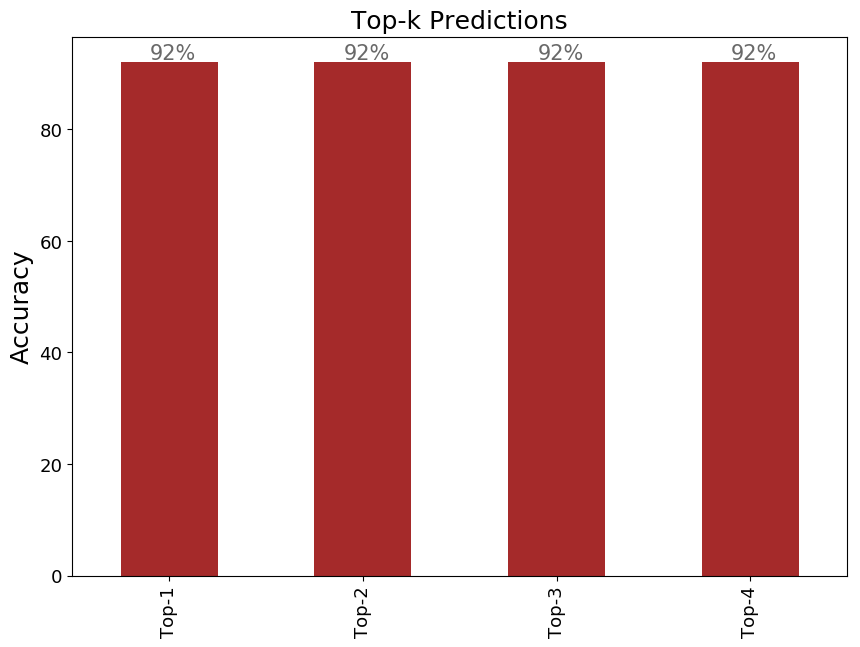

In [167]:
frequencies = [hit_top_1,hit_top_2,hit_top_3,hit_top_4]
freq_series = pd.Series.from_array(frequencies)
ax = freq_series.plot(kind='bar', figsize=(10,7),
                                        color="brown", fontsize=13);
ax.set_alpha(0.8)
ax.set_title('Top-k Predictions',fontsize=18)
ax.set_ylabel('Accuracy',fontsize=18)
ax.set_xticklabels(x_labels)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.15, i.get_height()+.5, \
            str(round((i.get_height()), 2))+'%', fontsize=15,
                color='dimgrey')

### Displaying predicted images for query image

In [56]:
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

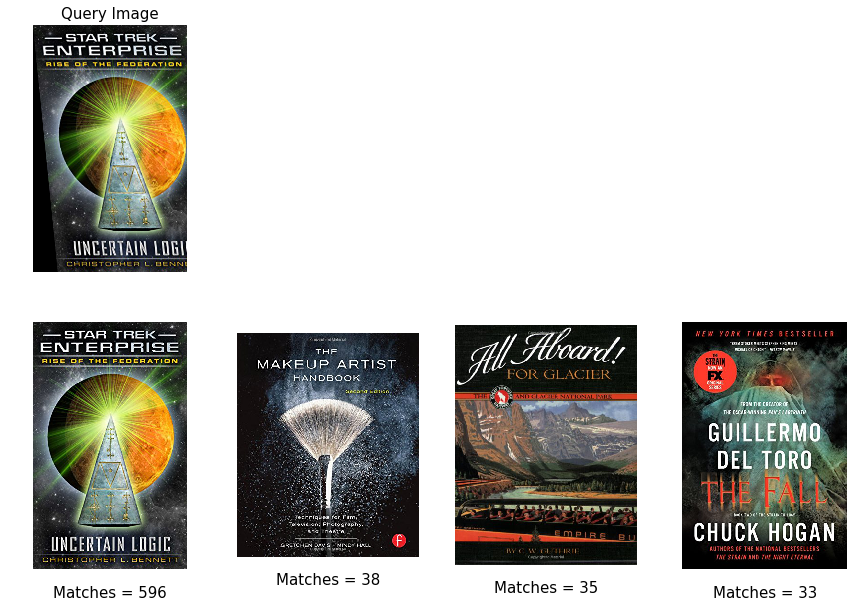

In [59]:
title_text = ""
plt.figure(figsize=(15,10))

# Loading query image
query_image = cv2.imread(predictions[query_image_number][0])
query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
plt.subplot(2, 4, 1)
plt.axis('off')
plt.title("Query Image",fontsize=15)
plt.imshow(query_image)

top_prediction_image = cv2.imread(predictions[query_image_number][1][0][1])
top_prediction_image = cv2.cvtColor(top_prediction_image, cv2.COLOR_BGR2RGB)

# Loading predicted images
for i in range(predictions_count):
    title_text = ""
    img = cv2.imread(predictions[query_image_number][1][i][1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    title_text = "Matches = " + str(predictions[query_image_number][1][i][0])
    plt.subplot(2,4,5+i)
    plt.axis('off')
    plt.text(0.5,-0.1,title_text,ha='center',va='center',fontsize=15,transform=plt.subplot(2,4,5+i).transAxes)
    plt.imshow(img)

plt.show()

### Drawing keypoints and matches for top predicted image

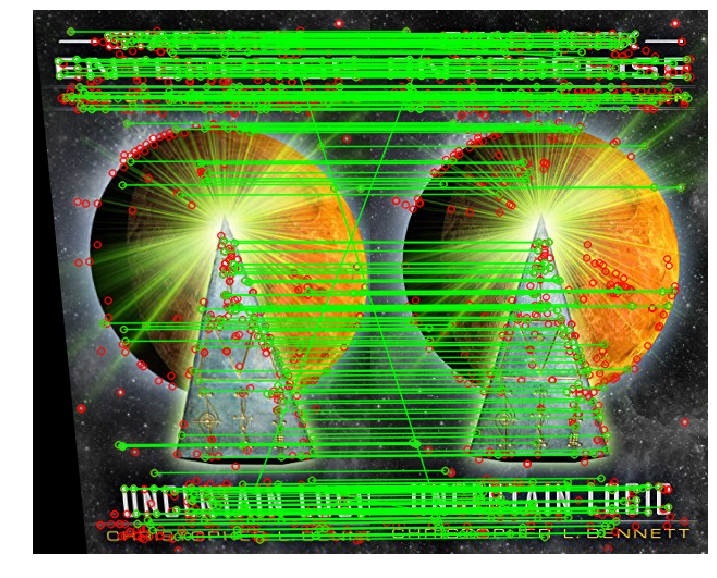

In [77]:
import random

q_kp,q_des = gen_sift_features(query_image)
m_kp,m_des = gen_sift_features(top_prediction_image)
matches_old = flann.knnMatch(q_des,m_des,k=2)
matches = random.sample(matches_old, 500)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < lowe_ratio*n.distance:
        matchesMask[i]=[1,0]
        
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

kp_img = cv2.drawMatchesKnn(query_image,q_kp,top_prediction_image,m_kp,matches,None,**draw_params)

plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(kp_img)
plt.show()

### Top predicted book details from Goodreads & Amazon

In [9]:
import requests
import csv
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen

In [10]:
import re
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

In [11]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [81]:
isbn = predictions[query_image_number][1][0][1].split("/")[-1].split(".")[0]
print(isbn)

1476779112


In [97]:
def book_details_goodreads(isbn):
    
    # Getting book title from Amazon
    amazon_base_url = "https://www.amazon.com/dp/"
    amazon_url = amazon_base_url + isbn
    req = Request(amazon_url, headers={'User-Agent': 'Mozilla/5.0'})
    page = urlopen(req).read().decode("utf-8")
    soup = BeautifulSoup(page, 'html.parser')
    
    a_title = soup.find_all("span",id="productTitle")
    a_title = str(a_title)
    a_title = remove_tags(a_title)
    a_title = a_title.strip("[]")
    a_title = a_title.strip()
    a_title_list = a_title.split(" ")
    
    # Goodreads Scraping
    goodreads_base_url = "https://www.goodreads.com/book/isbn/"
    goodreads_url = goodreads_base_url + isbn
    req = Request(goodreads_url, headers={'User-Agent': 'Mozilla/5.0'})
    page = urlopen(req).read().decode("utf-8")
    soup = BeautifulSoup(page, 'html.parser')
    
    # Book Title
    book_name = soup.find(itemprop="name")
    book_name = str(book_name)
    book_name = remove_tags(book_name)
    book_name = book_name.strip()
    book_name_list = book_name.split(" ")
    
    # Verifying if isbn is present in Goodreads by comparing book titles from Goodreads & Amazon
#     if str(a_title_list[0]).lower() != str(book_name_list[0]).lower():
#         return print("Book not found in Goodreads")
    
    # Author Names
    author_names = soup.find_all("span",itemprop="name")
    author_names = str(author_names)
    author_names = author_names.split(",")
    author_name = author_names[0]
    author_name = author_name.split(">")[1].split("<")[0]
    for i in range(len(author_names)):
        author_names[i] = author_names[i].split(">")[1].split("<")[0]
    
    author_names_text = ""
    for i in range(len(author_names)):
        author_names_text += str(author_names[i])
        author_names_text += ", "
        
    # Number of Ratings
    rating_count = soup.find(itemprop="ratingCount")
    rating_count = str(rating_count)
    rating_count = rating_count.split('"')[1]

    # Average Rating
    rating_val = soup.find(itemprop="ratingValue")
    rating_val = str(rating_val)
    rating_val = remove_tags(rating_val)
    
    # Number of pages in book
    pg_count = soup.find("meta",  property="books:page_count")
    pg_count = str(pg_count)
    pg_count = pg_count.split('"')[1]
    
    # Book Description
    desc = soup.find("div", id="description")
    if desc is not None:
        desc = desc.find_all("span",style="display:none")
        if desc is not None:
            desc = str(desc)
            desc = remove_tags(desc)
            description = desc.strip("[]")
            description = description.strip()
        else:
            description = "No description found"
    else:
        description = "No description found"

    # Printing book details from Goodreads
    printmd('**Book Details from Goodreads\n**')
    #print("Book Details from Goodreads\n")
    print("Book Title: ",book_name.splitlines()[0])
    #print("\n")
    print("Authors: ",author_names_text)
    #print("\n")
    print("Average Rating: ",rating_val)
    #print("\n")
    print("Number of ratings: ",rating_count)
    #print("\n")
    print("Number of pages in book: ",pg_count)
    print("\n")
    print("Book Description:")
    print("\n")
    print(description)

In [95]:
def book_details_amazon(isbn):
    
    # Amazon Scraping
    amazon_base_url = "https://www.amazon.com/dp/"
    amazon_url = amazon_base_url + isbn
    req = Request(amazon_url, headers={'User-Agent': 'Mozilla/5.0'})
    page = urlopen(req).read().decode("utf-8")
    soup = BeautifulSoup(page, 'html.parser')
    
    # Book title
    a_title = soup.find_all("span",id="productTitle")
    a_title = str(a_title)
    a_title = remove_tags(a_title)
    a_title = a_title.strip("[]")
    a_title = a_title.strip()
    
    # Book details
    book_info = []
    for li in soup.select('table#productDetailsTable div.content ul li'):
        try:
            title = li.b
            key = title.text.strip().rstrip(':')
            value = title.next_sibling.strip()
            value = value.strip("()")
            book_info.append((key,value))
        except AttributeError:
            break
            
    # Amazon reviews scraping
    amazon_review_base_url = "https://www.amazon.com/product-reviews/"
    amazon_review_url = amazon_review_base_url + isbn + "/ref=cm_cr_getr_d_paging_btm_2?pageNumber="
    req = Request(amazon_review_url, headers={'User-Agent': 'Mozilla/5.0'})
    page = urlopen(req).read().decode("utf-8")
    soup = BeautifulSoup(page, 'html.parser')
    
    # List of book reviews in Amazon
    reviews_list = []
    reviews_list_final = []
    for pg in range(1,5):
        amazon_review_url = amazon_review_base_url + isbn + "/ref=cm_cr_getr_d_paging_btm_2?pageNumber=" + str(pg)
        req = Request(amazon_review_url, headers={'User-Agent': 'Mozilla/5.0'})
        page = urlopen(req).read().decode("utf-8")
        soup = BeautifulSoup(page, 'html.parser')

        txt = soup.find("div", id="cm_cr-review_list")
        try:
            for rawreview in txt.find_all('span', {'class' : 'a-size-base review-text'}):
                text = rawreview.parent.parent.parent.text
                startindex = text.index('5 stars') + 7
                endindex = text.index('Was this review helpful to you?')
                text = text[startindex:endindex]
                text = text.split("Verified Purchase")[1]
                rText = text.split(".")[:-1]
                review_text = ""
                for i in range(len(rText)):
                    review_text += rText[i]
                    review_text += "."
                if review_text is not "":
                    if "|" not in review_text:
                        reviews_list.append(review_text)
                    else:
                        rText = text.split(".")[:-2]
                        review_text = ""
                        for x in range(len(rText)):
                            review_text += rText[x]
                            review_text += "."
                        reviews_list.append(review_text)
        except AttributeError:
            review_text = "No reviews found."
    
    if amazon_reviews_count < len(reviews_list):
        reviews_list_final = reviews_list[:amazon_reviews_count]
    else:
        reviews_list_final = reviews_list
        
    # Printing book details from Amazon
    printmd('**Book Details from Amazon\n**')
    #print("Book Details from Amazon\n")
    print("Book Title: ",a_title)
    #print("\n")
    for i in range(len(book_info)):
        print(f"{book_info[i][0]} : {book_info[i][1]}")
        #print("\n")
    print("\n")
    if len(reviews_list_final) == 0:
        print(review_text)
        print("\n")
    else:
        print(f"Displaying top {amazon_reviews_count} book reviews:\n")
        for i in range(len(reviews_list_final)):
            review_txt_list = reviews_list_final[i].split(".")[:3]
            review_txt = ""
            for j in range(len(review_txt_list)):
                review_txt += review_txt_list[j]
                review_txt += "."
            review_txt += ".."
            print(review_txt)
            print("\n")

In [98]:
book_details_goodreads(isbn)

**Book Details from Goodreads
**

Book Title:  Uncertain Logic
Authors:  Christopher L. Bennett, 
Average Rating:  4.08
Number of ratings:  324
Number of pages in book:  400


Book Description:


An original novel continuing the saga of the TV series Star Trek: Enterprise&amp;#8212;featuring Captain Jonathan Archer and the crew of the Enterprise!Years ago, Jonathan Archer and T&amp;#8217;Pol helped unearth the true writings of Vulcan&amp;#8217;s great philosopher Surak, bringing forth a new era of peaceful reform on Vulcan. But when their discovery is seemingly proven to be a fraud, the scandal threatens to undo a decade of progress and return power to the old, warlike regime. Admiral Archer, Captain T&amp;#8217;Pol, and the crew of the U.S.S. Endeavour investigate with help from their Vulcan allies, but none of them suspect the identity of the real mastermind behind the conspiracy to reconquer Vulcan&amp;#8212;or the price they will have to pay to discover the truth.Meanwhile, when a long-forgotten technological threa

In [96]:
book_details_amazon(isbn)

**Book Details from Amazon
**

Book Title:  Rise of the Federation: Uncertain Logic (Star Trek: Enterprise)
Series : Star Trek: Enterprise
Mass Market Paperback : 400 pages
Publisher : Pocket Books/Star Trek (March 24, 2015
Language : English
ISBN-10 : 1476779112
ISBN-13 : 978-1476779119
Product Dimensions : 4.1 x 1.1 x 6.8 inches
Shipping Weight : 6.4 ounces 
Average Customer Review : 
Amazon Best Sellers Rank : #704,656 in Books 


Displaying top 3 book reviews:

Another excellent installment in the ongoing Enterprise relaunch.  Of all the relaunch arcs I this one does the best job of staying true to what the TV series vision was. The story continues with the development of the Federation as it arrives on the galactic scene...


STAR TREK: UNCERTAIN LOGIC is the third volume of the Rise of the Federation series by Christopher Bennett and probably something I enjoy more than I ever did Enterprise itself. Don't get me wrong, my love of the series has improved over the years and it's (weirdly) my non-Trekkie wife's f